In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import random
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from loader import get_indole
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.DataStructs import TanimotoSimilarity


In [ ]:
n_generations = 20   
n_per_gen = 10    

core = get_indole()

substituents = [
    "[*]C", "[*]CC", "[*]OC", "[*]Cl", "[*]F",
    "[*]CN", "[*]C(=O)O", "[*][N+](=O)[O-]"
]


def get_available_carbons(mol):
    return [a.GetIdx() for a in mol.GetAtoms()
            if a.GetSymbol() == "C" and a.GetNumImplicitHs() > 0]

def attach_substituent(mol, sub_smiles):
    sub = Chem.MolFromSmiles(sub_smiles)
    if not sub:
        return None

    avail = get_available_carbons(mol)
    if not avail:
        return None
    atom_idx = random.choice(avail)

    try:
        combo = Chem.CombineMols(mol, sub)
        rw = Chem.RWMol(combo)

        mol_atoms = mol.GetNumAtoms()
        rw.AddBond(atom_idx, mol_atoms, Chem.BondType.SINGLE)

        newmol = rw.GetMol()
        Chem.SanitizeMol(newmol)
        return newmol
    except Exception:
        return None
def replace_dummies_with_carbons(mol):
    """Replace all dummy atoms [*] with carbon atoms and sanitize."""
    rw = Chem.RWMol(mol)
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:  
            atom.SetAtomicNum(6)      
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(2)
    newmol = rw.GetMol()
    Chem.SanitizeMol(newmol)
    return newmol
pool = [core]
unique_smiles = {Chem.MolToSmiles(core)}
for gen in range(n_generations):
    new_mols = []
    for mol in random.sample(pool, min(len(pool), n_per_gen)):
        sub = random.choice(substituents)
        newmol = attach_substituent(mol, sub)
        if newmol:
            newmol = replace_dummies_with_carbons(newmol)

            smi = Chem.MolToSmiles(newmol)
            if smi not in unique_smiles:
                unique_smiles.add(smi)
                new_mols.append(newmol)
    pool.extend(new_mols)

df = pd.DataFrame({"SMILES": sorted(unique_smiles)})
print(df.head(), f"\nTotal unique molecules: {len(df)}")
smiles = df['SMILES'].to_list()
mols = [Chem.MolFromSmiles(m) for m in df['SMILES'].to_list()]

                                             SMILES
0       CC(CF)Cc1c(CF)[nH]c2cc(COC(CF)CCl)cc(CF)c12
1                        CCC(CCN)OCc1c[nH]c2ccccc12
2            CCC(COC)OCc1c(CC(=O)O)cc2cc[nH]c2c1COC
3    CCC(N)CC(C[N+](=O)[O-])OCc1c[nH]c2c(CCN)cccc12
4  CCCC(N)(CC(=O)O)CC(CF)OCc1c(COC)cc2cc[nH]c2c1COC 
Total unique molecules: 169


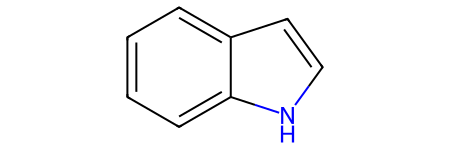

In [3]:
indole = get_indole()
indole

/home/henryteahan/miniconda/envs/catsper-freerelease/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


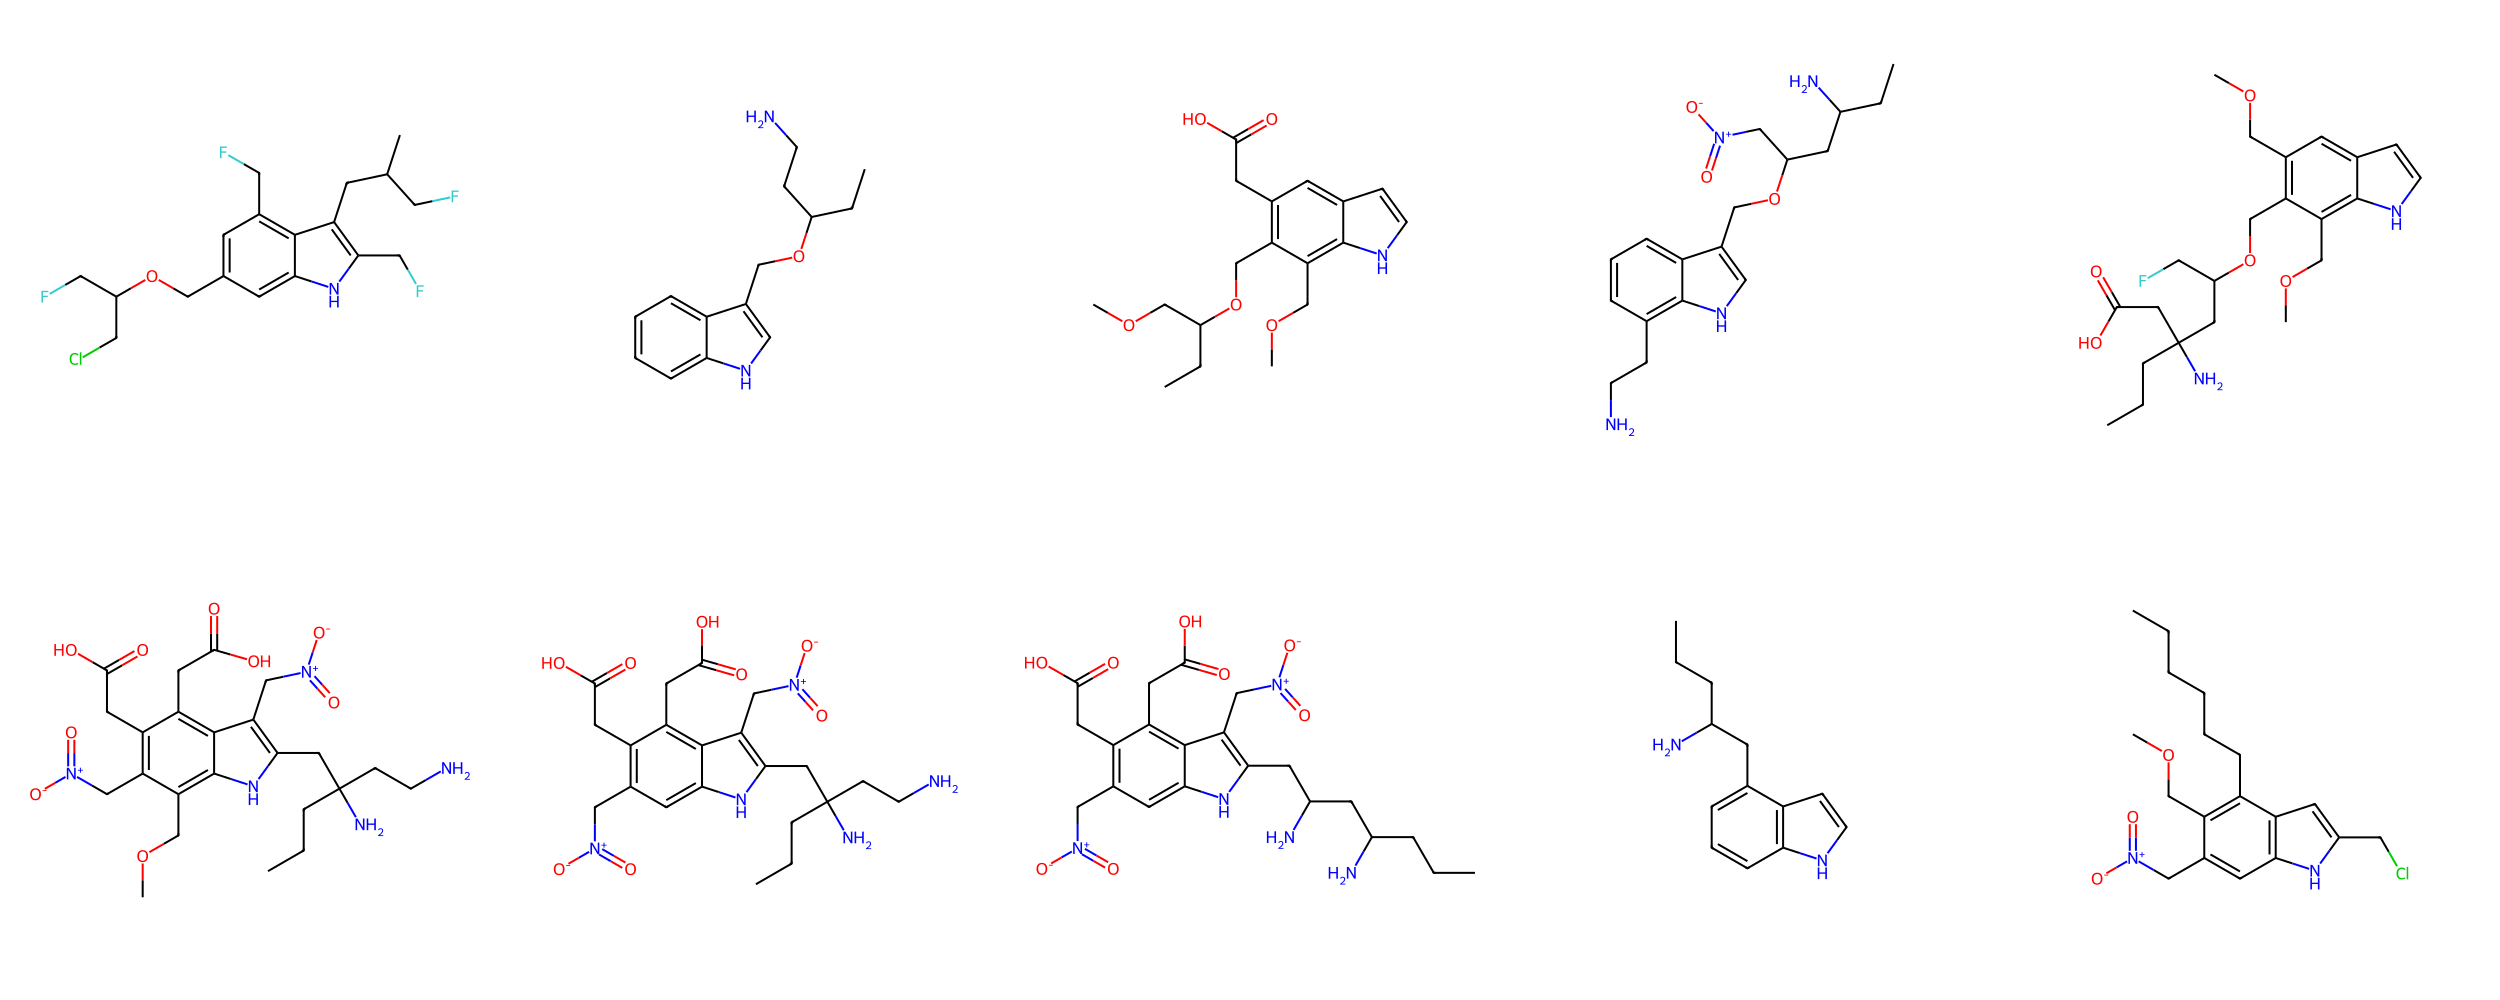

In [4]:
for m in mols:
    _ = AllChem.GenerateDepictionMatching2DStructure(m, indole)
Draw.MolsToGridImage(mols, subImgSize = (500,500), maxMols = 10, molsPerRow=5)

In [5]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
X = mfpgen.GetFingerprints(mols)

In [6]:
df = pd.DataFrame({"SMILES": smiles, "mols":mols, "X":X}) 
seed_smiles = random.sample(list(df['SMILES']), 5)

In [7]:
seed_indices = random.sample(range(len(df)), 10)
seed_fps = [df['X'][i] for i in seed_indices]

def is_active(fp, seed_fps, threshold=0.7):
    return any(TanimotoSimilarity(fp, s_fp) >= threshold for s_fp in seed_fps)

df['Active'] = [int(is_active(fp, seed_fps)) for fp in df['X']]

print(df.head())
print(f"Total actives: {df['Active'].sum()} / {len(df)}")


                                             SMILES  \
0       CC(CF)Cc1c(CF)[nH]c2cc(COC(CF)CCl)cc(CF)c12   
1                        CCC(CCN)OCc1c[nH]c2ccccc12   
2            CCC(COC)OCc1c(CC(=O)O)cc2cc[nH]c2c1COC   
3    CCC(N)CC(C[N+](=O)[O-])OCc1c[nH]c2c(CCN)cccc12   
4  CCCC(N)(CC(=O)O)CC(CF)OCc1c(COC)cc2cc[nH]c2c1COC   

                                               mols  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f34107e3920>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f34107e2e30>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f34107e3680>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f34107e37d0>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f34107e3840>   

                                                   X  Active  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...       1  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...       0  
4  [0, 1, 0, 0, 0, 0, 0

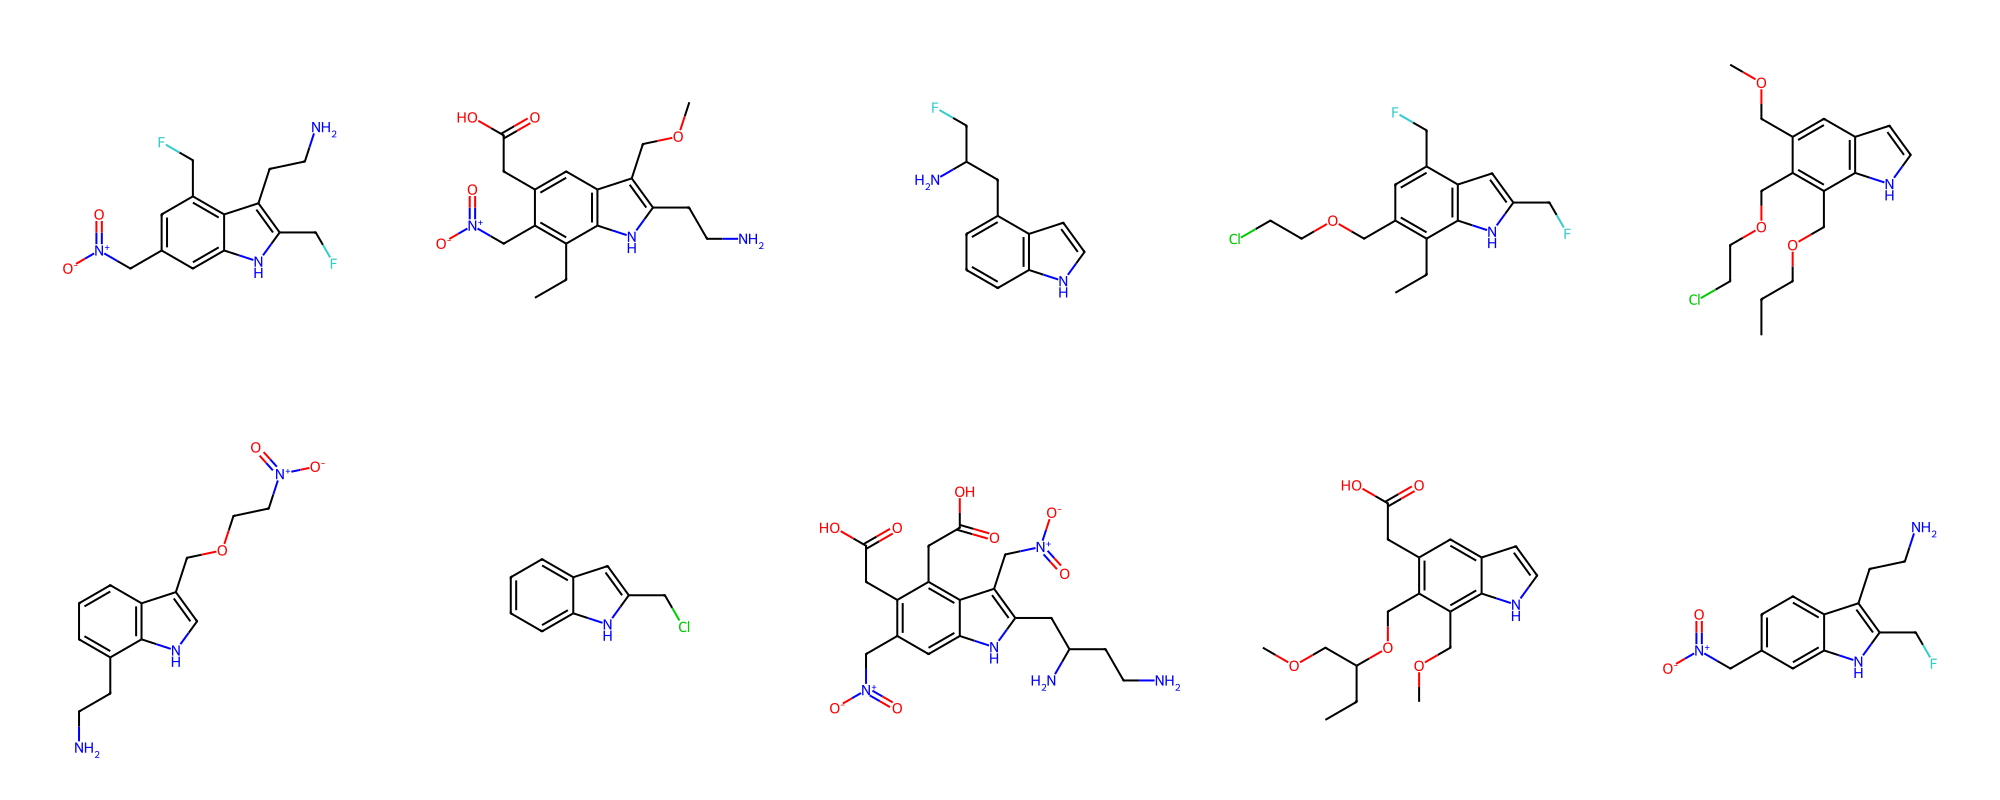

In [8]:
active_mols = [df['mols'][i] for i in seed_indices]
Chem.Draw.MolsToGridImage(active_mols, molsPerRow = 5, subImgSize = (400,400), maxMols = 15)

In [9]:
ic50s = df['Active'].to_list()
mols = df['mols'].to_list()
ic50s = [1 if ic50 == 1 else 100 for ic50 in ic50s] # Workflow expects continuous ic50 values
print(len(ic50s), len(mols))


writer = Chem.SDWriter("toy_indoles.sdf")
for m, ic in zip(mols, ic50s):
    m.SetProp("IC50", str(ic))
    writer.write(m)
writer.close()

169 169
